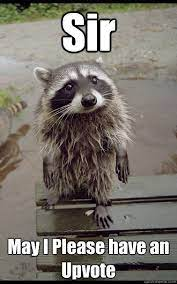

# PLEASE CHECKOUT MY NEW DATASET
- https://www.kaggle.com/keagle/mountains-dataset-with-coordinates-and-countries
- https://www.kaggle.com/keagle/list-of-indian-festivals-for-2022

Based on previous works
# Petfinder.my - Pawpularity Contest: Simple EDA and fastai starter

## A look at the data
Let's start out by setting up our environment by importing the required modules and setting a random seed:

モジュールのインポートとシード値の設定
* timm
    * Pytorchの画像系のモデルや最適化手法(NAdamなど)が実装されているライブラリ
    * timmモジュールのcreate_modelを用いることで、指定されたモデルを取得できる

In [ ]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
from timm import create_model

* fastai
    * 深層学習ライブラリ
    * fastaiは最も簡単に深層学習を行うことができるPythonのパッケージ
* Kaggleの画像コンペではfast.aiベースの解法がKernel上でよく共有されるため，主な流れを抑えておくに越したことはない。
* あくまでお試し用のライブラリで煩雑な部分が一切無いため、簡単にNNを組むことができる。fast.aiを極める意味はあまりない
* 処理の流れは以下。
1. dataの定義(場合によってはここでtransform)
2. modelの定義
3. metricsの定義
4. learnerの定義
5. learnerのfit(..)
6. model.get_preds(..)

In [ ]:
from fastai.vision.all import *

In [ ]:
set_seed(999, reproducible=True)
BATCH_SIZE = 32

Let's check what data is available to us:

どんなデータがあるのか確認してみよう

In [ ]:
dataset_path = Path('../input/petfinder-pawpularity-score/')
dataset_path.ls()

We can see that we have our train csv file with the train image names, metadata and labels, the test csv file with test image names and metadata, the sample submission csv with the test image names, and the train and test image folders.

Let's check the train csv file:

訓練画像の名前、メタデータ、ラベルが入った訓練csvファイル、テスト画像の名前とメタデータが入ったテストcsvファイル、テスト画像の名前が入ったサンプル投稿csv、訓練画像とテスト画像のフォルダがあることがわかります。

訓練データを見てみる

In [ ]:
train_df = pd.read_csv(dataset_path/'train.csv')
train_df.head()

The metadata provided includes information about key visual quality and composition parameters of the photos. The Pawpularity Score is derived from the profile's page view statistics. This is the target we are aiming to predict.

メタデータには、写真の主要な視覚的品質と構成パラメータに関する情報が含まれます。Pawpularity Scoreは、プロフィールのページビュー統計から導き出されます。

このpawpurarityスコアの精度を良くするのが今回の目的になっている。

Let's do some quick processing of the image filenames to make it easier to access:

アクセスしやすいように画像ファイルの名前を簡単に加工する。

* pandas.sampleで行列をランダムでサンプリング(抽出)
* 引数fracで抽出する行・列の割合を指定できる。1だと100%

In [ ]:
train_df['path'] = train_df['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head()

Okay, let's check how many images are available in the training dataset:

訓練データセットに何枚画像があるかチェック

In [ ]:
len_df = len(train_df)
print(f"There are {len_df} images")

Let's check the distribution of the Pawpularity Score:

pawpurarityスコア分布の確認


pd.hist: ヒストグラムの作成
figsize: figure_size -> 生成される画像サイズ(単位：インチ)

In [ ]:
train_df['Pawpularity'].hist(figsize = (10, 5))
print(f"The mean Pawpularity score is {train_df['Pawpularity'].mean()}")
print(f"The median Pawpularity score is {train_df['Pawpularity'].median()}")
print(f"The standard deviation of the Pawpularity score is {train_df['Pawpularity'].std()}")

In [ ]:
print(f"There are {len(train_df['Pawpularity'].unique())} unique values of Pawpularity score")

Note that the Pawpularity score is an integer, so in addition to being a regression problem, it could also be treated as a 100-class classification problem. Alternatively, it can be treated as a binary classification problem if the Pawpularity Score is normalized between 0 and 1:

Pawpularity Scoreは整数なので、回帰問題であることに加えて、100クラスの分類問題としても扱うことができる。

また、Pawpularity Scoreが0と1の間で正規化されている場合は、二値分類問題として扱うこともできる。

In [ ]:
train_df['norm_score'] = train_df['Pawpularity']/100
train_df['norm_score']

Let's check an example image to see what it looks like:

画像の例をみてみる

In [ ]:
im = Image.open(train_df['path'][1])
width, height = im.size
print(width,height)

In [ ]:
im

## Data loading
After my quick 'n dirty EDA, let's load the data into fastai as DataLoaders objects. We're using the normalized score as the label. I use some fairly basic augmentations here.

EDAの後、データをDataLoadersオブジェクトとしてfastaiにロードする。

ラベルには正規化したスコアを使う。

In [ ]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'


#### シードの初期設定(重要)
再現性のある学習を行うために、コードのはじめに設定する。引数としてのseedは任意の数字を入れる。

様々な段階で乱数を使っているで、完全再現のためには忘れずに設定。

* set_seed: 乱数を生成するときの最初の設定値(シード)を決める
* manual_seed: シードの固定
* backends.cudnn.deterministic: lossが毎回変わる問題を解消(determin->決定とか)
* use_deterministic_algorithms: 決定的アルゴリズムの使用

In [ ]:
seed=999
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

スタージェスの公式を使う。->ヒストグラムの階級数の決め方

スタージェスの公式：”1+log2n”

In [ ]:
#Sturges' rule
num_bins = int(np.floor(1+(3.3)*(np.log2(len(train_df)))))
# num_bins

#### pd.cutでビン分割
ビニング処理（ビン分割）とは、連続値を任意の境界値で区切りカテゴリ分けして離散値に変換する処理のこと。

機械学習の前処理として行われることが多い。

In [ ]:
train_df['bins'] = pd.cut(train_df['norm_score'], bins=num_bins, labels=False)
train_df['bins'].hist()

### K分割交差検証
* KFold
    * データをk個に分け，n個を訓練用，k-n個をテスト用として使う．
    * 分けられたn個のデータがテスト用として必ず1回使われるようにn回検定する．
* オプション(引数)
    * n_split：データの分割数．つまりk．検定はここで指定した数値の回数おこなわれる．
    * shuffle：Trueなら連続する数字でグループ分けせず，ランダムにデータを選択する．
    * random_state：乱数のシードを指定できる．
    
#### 層状K分割
* StratifiedKFold
    * 分布に大きな不均衡がある場合に用いるKFold．
    * 分布の比率を維持したままデータを訓練用とテスト用に分割する．
* オプション(引数)
    * KFoldと同じ．
    * n_splitがデータ数が最も少ないクラスのデータ数よりも多いと怒られる．

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

train_df['fold'] = -1


N_FOLDS = 10
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['bins'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

train_df.fold.value_counts().plot.bar()

(n_splits=N_FOLDS): データを10個(N_FOLDS)にする。


つまりtrain_df['fold']==0は分割したデータの1つ目

In [ ]:
train_df[train_df['fold']==0].head()

ビン(連続値を任意の境界値で区切りカテゴリ分けして離散値に変換したもの)に含まれる要素数

In [ ]:
train_df[train_df['fold']==0]['bins'].value_counts()

In [ ]:
train_df[train_df['fold']==1]['bins'].value_counts()

#### 平均2乗誤差の平方根を算出する関数

In [ ]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

* fastai: ImageDataLoaders.from_df
    * fn_colとlabel_colを用いてdfを作成する

In [ ]:
def get_data(fold):
#     train_df_no_val = train_df.query(f'fold != {fold}')
#     train_df_val = train_df.query(f'fold == {fold}')
    
#     train_df_bal = pd.concat([train_df_no_val,train_df_val.sample(frac=1).reset_index(drop=True)])
    train_df_f = train_df.copy()
    # add is_valid for validation fold
    train_df_f['is_valid'] = (train_df_f['fold'] == fold)
    
    dls = ImageDataLoaders.from_df(train_df_f, #pass in train DataFrame
#                                valid_pct=0.2, #80-20 train-validation random split
                               valid_col='is_valid', #
                               seed=999, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms
    
    return dls


* assert
    * プログラムの内部セルフチェックとして条件をテストするデバッグ支援ツール
    * アサーションは開発者によるバグの特定を助けるために使用すべきものであり、ランタイムエラーに対処するためのメカニズムではない

In [ ]:
#Valid Kfolder size
the_data = get_data(0)
assert (len(the_data.train) + len(the_data.valid)) == (len(train_df)//BATCH_SIZE)

## 学習

In [ ]:
def get_learner(fold_num):
    data = get_data(fold_num)
    
    model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=data.c)

    learn = Learner(data, model, loss_func=BCEWithLogitsLossFlat(), metrics=petfinder_rmse).to_fp16()
    
    return learn

In [ ]:
test_df = pd.read_csv(dataset_path/'test.csv')
test_df.head()

test_dfのPawpurarityスコアを1で置く

In [ ]:
test_df['Pawpularity'] = [1]*len(test_df)
test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
test_df = test_df.drop(columns=['Id'])
train_df['norm_score'] = train_df['Pawpularity']/100

学習する

In [ ]:
get_learner(fold_num=0).lr_find(end_lr=3e-2)

In [ ]:
import gc

In [ ]:
all_preds = []

for i in range(N_FOLDS):

    print(f'Fold {i} results')
    
    learn = get_learner(fold_num=i)

    learn.fit_one_cycle(5, 2e-5, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=2)]) 
    
    learn.recorder.plot_loss()

    #learn = learn.to_fp32()
    
    #learn.export(f'model_fold_{i}.pkl')
    #learn.save(f'model_fold_{i}.pkl')
    
    dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
                               valid_pct=0.2, #80-20 train-validation random split
                               seed=999, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) 
    
    test_dl = dls.test_dl(test_df)
    
    preds, _ = learn.tta(dl=test_dl, n=5, beta=0)
    
    all_preds.append(preds)
    
    del learn

    torch.cuda.empty_cache()

    gc.collect()

In [ ]:
all_preds

In [ ]:
np.mean(np.stack(all_preds*100))

In [ ]:
sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
preds = np.mean(np.stack(all_preds), axis=0)
sample_df['Pawpularity'] = preds*100
sample_df.to_csv('submission.csv',index=False)

In [ ]:
pd.read_csv('submission.csv').head()

In [ ]:
#path = './models'
#learn1 = load_learner('model_fold_2.pkl')

# Model training

Let's train a Swin Transformer model as a baseline. We will use the wonderful timm package by Ross Wightman to define the model. Since this competition doesn't allow internet access, I have added the pretrained weights from timm as a dataset, and the below code cell will allow timm to find the file:

Let's now define the model.

Let's also define the metric we will use. Note that we multiply by 100 to get a relevant RMSE for Pawpularity Score prediction, not prediction of the normalized score.

In fastai, the trainer class is the `Learner`, which takes in the data, model, optimizer, loss function, etc. and allows you to train models, make predictions, etc. Let's define the `Learner` for this task, and also use mixed precision. Note that we use `BCEWithLogitsLoss` to treat this as a classification problem.

We are now provided with a Learner object. In order to train a model, we need to find the most optimal learning rate, which can be done with fastai's learning rate finder:

Let's now fine-tune the model with the desired learning rate of 2e-5. We'll save the best model and use the early stopping callback.

We plotted the loss, put the model back to fp32, and now we can export the model if we want to use later (i.e. for an inference kernel):

## Inference

It's very simple to perform inference with fastai. We preprocess the test CSV in the same way as the train CSV, and the `dls.test_dl` function allows you to create test dataloader using the same pipeline we defined earlier.

In [ ]:
# test_df = pd.read_csv(dataset_path/'test.csv')
# test_df.head()

In [ ]:
# test_df['Pawpularity'] = [1]*len(test_df)
# test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
# test_df = test_df.drop(columns=['Id'])
# train_df['norm_score'] = train_df['Pawpularity']/100

In [ ]:
# dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
#                                valid_pct=0.2, #80-20 train-validation random split
#                                seed=999, #seed
#                                fn_col='path', #filename/path is in the second column of the DataFrame
#                                label_col='norm_score', #label is in the first column of the DataFrame
#                                y_block=RegressionBlock, #The type of target
#                                bs=32, #pass in batch size
#                                num_workers=8,
#                                item_tfms=Resize(224), #pass in item_tfms
#                                batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) 
# test_dl = dls.test_dl(test_df)

In [ ]:
# test_dl.show_batch()

We can easily confirm that the test_dl is correct (the example test images provided are just noise so this is expected):

Now let's pass the dataloader to the model and get predictions. Here I am using 5x test-time augmentation which further improves model performance.

In [ ]:
#preds, _ = learn1.tta(dl=test_dl, n=5, beta=0)

Let's make a submission with these predictions!

In [ ]:
# sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
# sample_df['Pawpularity'] = preds.float().numpy()*100
# sample_df.to_csv('submission.csv',index=False)

In [ ]:
#pd.read_csv('submission.csv').head()

Now, **WE ARE DONE!**

If you enjoyed this notebook, please give it an upvote. 

Stay tuned for improvements to this notebook, potentially including a version that uses the metadata as well.

If you have any questions or suggestions, please leave a comment!